<a href="https://colab.research.google.com/github/NileshPranami/AlgoCode/blob/master/entail2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
cd drive/My\ Drive/Entailment1/Data

/content/drive/My Drive/Entailment1/Data


In [0]:

glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [15]:
!pwd

/content/drive/My Drive/Entailment1/Data


In [0]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

In [0]:

glove_wordmap={}
with open(glove_vectors_file,"r")as glove:
  for line in glove:
    name,vector=tuple(line.split(" ",1))
    glove_wordmap[name]=np.fromstring(vector, sep=" ")

In [0]:
def sentence2sequence(sentence):
  tokens = sentence.lower().split(" ")
  rows= []
  words= []
  for token in tokens:
    i = len(token)
    while len(token)>0 and i>0:
      word=token[:i]
      if word in glove_wordmap:
        rows.append(glove_wordmap[word])
        words.append(word)
        token = token[i:]
        i=len(token)
      else:
        i = i-1
  return rows, words
        
        

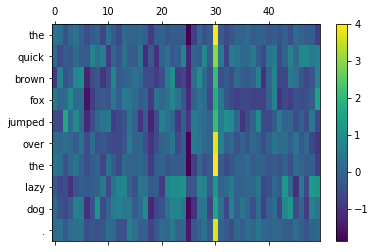

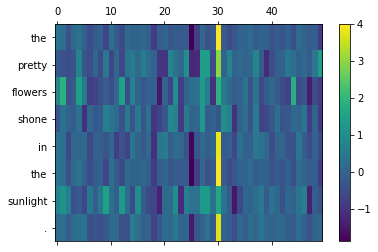

In [19]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [20]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

W0820 05:31:59.325688 139806498416512 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0820 05:31:59.327502 139806498416512 deprecation.py:323] From <ipython-input-20-33127d7a5f16>:2: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

In [22]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_train.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [0]:
tf.reset_default_graph()

In [24]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

W0820 05:33:46.356750 139806498416512 deprecation.py:323] From <ipython-input-24-9e22ebd21dd7>:1: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

In [26]:
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')


lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)

lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)

fc_initializer = tf.random_normal_initializer(stddev=0.1)

fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)

fc_bias = tf.get_variable('bias', [3])

tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1)

x = tf.transpose(x, [1, 0, 2]) 

x = tf.reshape(x, [-1, vector_size]) 

x = tf.split(x, l_seq,)

rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias

W0820 05:33:46.479149 139806498416512 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 05:33:46.499139 139806498416512 deprecation.py:323] From <ipython-input-26-e921aebe580d>:29: static_bidirectional_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
W0820 05:33:46.502326 139806498416512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/rnn.py:1610: static_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for u

In [27]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

W0820 05:33:49.095939 139806498416512 deprecation.py:323] From <ipython-input-27-97a0fabce845>:10: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [32]:
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))



  0%|          | 3/782 [00:02<25:10,  1.94s/it]

Iter 0.0, Minibatch Loss= 1.114623, Training Accuracy= 0.28906


  2%|▏         | 13/782 [00:03<04:50,  2.65it/s]

Iter 10.0, Minibatch Loss= 1.096588, Training Accuracy= 0.32812


  3%|▎         | 23/782 [00:04<01:27,  8.65it/s]

Iter 20.0, Minibatch Loss= 1.086597, Training Accuracy= 0.39062


  4%|▍         | 33/782 [00:04<00:54, 13.74it/s]

Iter 30.0, Minibatch Loss= 1.096586, Training Accuracy= 0.35156


  5%|▌         | 43/782 [00:05<00:46, 15.89it/s]

Iter 40.0, Minibatch Loss= 1.078456, Training Accuracy= 0.35938


  7%|▋         | 53/782 [00:05<00:45, 16.20it/s]

Iter 50.0, Minibatch Loss= 1.087934, Training Accuracy= 0.39844


  8%|▊         | 63/782 [00:06<00:44, 16.12it/s]

Iter 60.0, Minibatch Loss= 1.076259, Training Accuracy= 0.42188


  9%|▉         | 73/782 [00:07<00:44, 15.81it/s]

Iter 70.0, Minibatch Loss= 1.091895, Training Accuracy= 0.35938


 11%|█         | 83/782 [00:07<00:43, 16.12it/s]

Iter 80.0, Minibatch Loss= 1.045976, Training Accuracy= 0.43750


 12%|█▏        | 93/782 [00:08<00:41, 16.46it/s]

Iter 90.0, Minibatch Loss= 1.059779, Training Accuracy= 0.46875


 13%|█▎        | 103/782 [00:09<00:42, 16.04it/s]

Iter 100.0, Minibatch Loss= 1.062995, Training Accuracy= 0.47656


 14%|█▍        | 113/782 [00:09<00:40, 16.38it/s]

Iter 110.0, Minibatch Loss= 1.057587, Training Accuracy= 0.44531


 16%|█▌        | 123/782 [00:10<00:39, 16.60it/s]

Iter 120.0, Minibatch Loss= 1.093066, Training Accuracy= 0.38281


 17%|█▋        | 133/782 [00:10<00:40, 16.22it/s]

Iter 130.0, Minibatch Loss= 1.074063, Training Accuracy= 0.41406


 18%|█▊        | 143/782 [00:11<00:39, 16.38it/s]

Iter 140.0, Minibatch Loss= 1.076091, Training Accuracy= 0.46094


 20%|█▉        | 153/782 [00:12<00:38, 16.40it/s]

Iter 150.0, Minibatch Loss= 1.069584, Training Accuracy= 0.37500


 21%|██        | 163/782 [00:12<00:37, 16.48it/s]

Iter 160.0, Minibatch Loss= 1.081597, Training Accuracy= 0.41406


 22%|██▏       | 173/782 [00:13<00:37, 16.40it/s]

Iter 170.0, Minibatch Loss= 1.074992, Training Accuracy= 0.40625


 23%|██▎       | 183/782 [00:13<00:36, 16.28it/s]

Iter 180.0, Minibatch Loss= 1.087855, Training Accuracy= 0.35156


 25%|██▍       | 193/782 [00:14<00:36, 16.32it/s]

Iter 190.0, Minibatch Loss= 1.033290, Training Accuracy= 0.46094


 26%|██▌       | 203/782 [00:15<00:35, 16.31it/s]

Iter 200.0, Minibatch Loss= 1.065310, Training Accuracy= 0.45312


 27%|██▋       | 213/782 [00:15<00:34, 16.39it/s]

Iter 210.0, Minibatch Loss= 1.029575, Training Accuracy= 0.50000


 29%|██▊       | 223/782 [00:16<00:34, 16.23it/s]

Iter 220.0, Minibatch Loss= 1.086309, Training Accuracy= 0.38281


 30%|██▉       | 233/782 [00:16<00:34, 15.97it/s]

Iter 230.0, Minibatch Loss= 1.086535, Training Accuracy= 0.38281


 31%|███       | 243/782 [00:17<00:34, 15.83it/s]

Iter 240.0, Minibatch Loss= 1.069238, Training Accuracy= 0.42969


 32%|███▏      | 253/782 [00:18<00:32, 16.41it/s]

Iter 250.0, Minibatch Loss= 1.093048, Training Accuracy= 0.38281


 34%|███▎      | 263/782 [00:18<00:31, 16.30it/s]

Iter 260.0, Minibatch Loss= 1.101506, Training Accuracy= 0.35938


 35%|███▍      | 273/782 [00:19<00:30, 16.60it/s]

Iter 270.0, Minibatch Loss= 1.038988, Training Accuracy= 0.44531


 36%|███▌      | 283/782 [00:19<00:29, 16.64it/s]

Iter 280.0, Minibatch Loss= 1.020691, Training Accuracy= 0.47656


 37%|███▋      | 293/782 [00:20<00:29, 16.56it/s]

Iter 290.0, Minibatch Loss= 1.067288, Training Accuracy= 0.44531


 39%|███▊      | 303/782 [00:21<00:28, 16.60it/s]

Iter 300.0, Minibatch Loss= 1.046315, Training Accuracy= 0.39062


 40%|████      | 313/782 [00:21<00:28, 16.48it/s]

Iter 310.0, Minibatch Loss= 1.043247, Training Accuracy= 0.44531


 41%|████▏     | 323/782 [00:22<00:27, 16.63it/s]

Iter 320.0, Minibatch Loss= 1.051983, Training Accuracy= 0.44531


 43%|████▎     | 333/782 [00:22<00:27, 16.14it/s]

Iter 330.0, Minibatch Loss= 1.046402, Training Accuracy= 0.46094


 44%|████▍     | 343/782 [00:23<00:26, 16.40it/s]

Iter 340.0, Minibatch Loss= 1.065973, Training Accuracy= 0.42188


 45%|████▌     | 353/782 [00:24<00:26, 16.46it/s]

Iter 350.0, Minibatch Loss= 1.018382, Training Accuracy= 0.48438


 46%|████▋     | 363/782 [00:24<00:25, 16.43it/s]

Iter 360.0, Minibatch Loss= 1.078800, Training Accuracy= 0.38281


 48%|████▊     | 373/782 [00:25<00:25, 16.32it/s]

Iter 370.0, Minibatch Loss= 1.060813, Training Accuracy= 0.37500


 49%|████▉     | 383/782 [00:25<00:24, 16.41it/s]

Iter 380.0, Minibatch Loss= 1.015079, Training Accuracy= 0.47656


 50%|█████     | 393/782 [00:26<00:23, 16.60it/s]

Iter 390.0, Minibatch Loss= 1.027639, Training Accuracy= 0.44531


 52%|█████▏    | 403/782 [00:27<00:23, 16.43it/s]

Iter 400.0, Minibatch Loss= 0.964136, Training Accuracy= 0.54688


 53%|█████▎    | 413/782 [00:27<00:23, 15.90it/s]

Iter 410.0, Minibatch Loss= 1.017640, Training Accuracy= 0.47656


 54%|█████▍    | 423/782 [00:28<00:21, 16.49it/s]

Iter 420.0, Minibatch Loss= 1.048763, Training Accuracy= 0.47656


 55%|█████▌    | 433/782 [00:28<00:21, 16.46it/s]

Iter 430.0, Minibatch Loss= 1.059130, Training Accuracy= 0.45312


 57%|█████▋    | 443/782 [00:29<00:20, 16.68it/s]

Iter 440.0, Minibatch Loss= 1.034734, Training Accuracy= 0.45312


 58%|█████▊    | 453/782 [00:30<00:19, 16.68it/s]

Iter 450.0, Minibatch Loss= 1.030533, Training Accuracy= 0.53125


 59%|█████▉    | 463/782 [00:30<00:19, 16.62it/s]

Iter 460.0, Minibatch Loss= 1.053275, Training Accuracy= 0.41406


 60%|██████    | 473/782 [00:31<00:18, 16.56it/s]

Iter 470.0, Minibatch Loss= 1.061758, Training Accuracy= 0.37500


 62%|██████▏   | 483/782 [00:31<00:18, 16.17it/s]

Iter 480.0, Minibatch Loss= 1.063056, Training Accuracy= 0.42969


 63%|██████▎   | 493/782 [00:32<00:17, 16.51it/s]

Iter 490.0, Minibatch Loss= 1.061260, Training Accuracy= 0.41406


 64%|██████▍   | 503/782 [00:33<00:17, 16.23it/s]

Iter 500.0, Minibatch Loss= 1.012679, Training Accuracy= 0.47656


 66%|██████▌   | 513/782 [00:33<00:17, 15.55it/s]

Iter 510.0, Minibatch Loss= 1.045418, Training Accuracy= 0.43750


 67%|██████▋   | 523/782 [00:34<00:15, 16.27it/s]

Iter 520.0, Minibatch Loss= 1.070409, Training Accuracy= 0.51562


 68%|██████▊   | 533/782 [00:34<00:15, 16.57it/s]

Iter 530.0, Minibatch Loss= 1.012543, Training Accuracy= 0.46094


 69%|██████▉   | 543/782 [00:35<00:14, 16.71it/s]

Iter 540.0, Minibatch Loss= 0.999442, Training Accuracy= 0.46875


 71%|███████   | 553/782 [00:36<00:13, 16.55it/s]

Iter 550.0, Minibatch Loss= 1.046087, Training Accuracy= 0.46094


 72%|███████▏  | 563/782 [00:36<00:13, 16.03it/s]

Iter 560.0, Minibatch Loss= 1.036414, Training Accuracy= 0.51562


 73%|███████▎  | 573/782 [00:37<00:12, 16.16it/s]

Iter 570.0, Minibatch Loss= 1.008485, Training Accuracy= 0.52344


 75%|███████▍  | 583/782 [00:37<00:12, 16.04it/s]

Iter 580.0, Minibatch Loss= 1.041790, Training Accuracy= 0.41406


 76%|███████▌  | 593/782 [00:38<00:11, 16.43it/s]

Iter 590.0, Minibatch Loss= 1.043074, Training Accuracy= 0.46094


 77%|███████▋  | 603/782 [00:39<00:11, 16.26it/s]

Iter 600.0, Minibatch Loss= 1.020310, Training Accuracy= 0.52344


 78%|███████▊  | 613/782 [00:39<00:10, 16.53it/s]

Iter 610.0, Minibatch Loss= 1.034269, Training Accuracy= 0.50000


 80%|███████▉  | 623/782 [00:40<00:09, 16.54it/s]

Iter 620.0, Minibatch Loss= 1.042195, Training Accuracy= 0.46094


 81%|████████  | 633/782 [00:40<00:09, 16.15it/s]

Iter 630.0, Minibatch Loss= 1.039908, Training Accuracy= 0.48438


 82%|████████▏ | 643/782 [00:41<00:08, 16.29it/s]

Iter 640.0, Minibatch Loss= 1.046099, Training Accuracy= 0.39844


 84%|████████▎ | 653/782 [00:42<00:07, 16.36it/s]

Iter 650.0, Minibatch Loss= 1.025730, Training Accuracy= 0.46875


 85%|████████▍ | 663/782 [00:42<00:07, 16.40it/s]

Iter 660.0, Minibatch Loss= 0.990089, Training Accuracy= 0.49219


 86%|████████▌ | 673/782 [00:43<00:06, 16.27it/s]

Iter 670.0, Minibatch Loss= 0.959233, Training Accuracy= 0.53906


 87%|████████▋ | 683/782 [00:43<00:06, 16.32it/s]

Iter 680.0, Minibatch Loss= 0.994353, Training Accuracy= 0.46094


 89%|████████▊ | 693/782 [00:44<00:05, 16.26it/s]

Iter 690.0, Minibatch Loss= 1.005555, Training Accuracy= 0.49219


 90%|████████▉ | 703/782 [00:45<00:04, 16.10it/s]

Iter 700.0, Minibatch Loss= 1.039468, Training Accuracy= 0.43750


 91%|█████████ | 713/782 [00:45<00:04, 16.15it/s]

Iter 710.0, Minibatch Loss= 0.979108, Training Accuracy= 0.55469


 92%|█████████▏| 723/782 [00:46<00:03, 16.37it/s]

Iter 720.0, Minibatch Loss= 1.018807, Training Accuracy= 0.47656


 94%|█████████▎| 733/782 [00:46<00:03, 16.02it/s]

Iter 730.0, Minibatch Loss= 1.011676, Training Accuracy= 0.51562


 95%|█████████▌| 743/782 [00:47<00:02, 16.30it/s]

Iter 740.0, Minibatch Loss= 1.023548, Training Accuracy= 0.50781


 96%|█████████▋| 753/782 [00:48<00:01, 16.10it/s]

Iter 750.0, Minibatch Loss= 1.013515, Training Accuracy= 0.46875


 98%|█████████▊| 763/782 [00:48<00:01, 15.85it/s]

Iter 760.0, Minibatch Loss= 0.958276, Training Accuracy= 0.56250


 99%|█████████▉| 773/782 [00:49<00:00, 16.31it/s]

Iter 770.0, Minibatch Loss= 1.047747, Training Accuracy= 0.47656


100%|██████████| 782/782 [00:49<00:00, 15.67it/s]

Iter 780.0, Minibatch Loss= 1.004328, Training Accuracy= 0.44531


In [40]:
evidences = ["He likes to play cricket"]

hypotheses = ["He not likes to play cricket"]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

Negative entailment


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
